In [328]:
import numpy as np
import pandas as pd
from pylatex import Document, Section, Subsection, Table, Math, TikZ, Axis, \
    Plot, Figure, Package
from pylatex.numpy import Matrix
from pylatex.utils import italic, escape_latex
import re

import glob
import os
import sys
from TexSoup import TexSoup
import math


In [329]:
conferences_df = pd.read_csv("conferences_df.csv") 

In [330]:
len(list(conferences_df['download_id']))

137

# Data cleaning and feature extraction

In [331]:
conferences_df.columns

Index(['entry_id', 'updated', 'published', 'title', 'authors', 'summary',
       'comment', 'journal_ref', 'doi', 'primary_category', 'categories',
       'links', 'pdf_url', '_raw', 'download_id', 'download', 'conference',
       'number_of_words_abstract', 'Abstarct', 'number_of_sections',
       'number_of_subsections', 'number_of_Tables', 'number_of_Figures',
       'uncommented_data', 'avg_captions_len'],
      dtype='object')

In [332]:
'''conferences_df["uncommented_data"] = ""
conferences_df["Abstarct"] = ""
conferences_df["number_of_words_abstract"] = ""
conferences_df["number_of_sections"] = ""
conferences_df["number_of_subsections"] = ""
conferences_df["number_of_Tables"] = ""
conferences_df["number_of_Figures"] = ""
conferences_df["avg_captions_len"] = ""
'''

'conferences_df["uncommented_data"] = ""\nconferences_df["Abstarct"] = ""\nconferences_df["number_of_words_abstract"] = ""\nconferences_df["number_of_sections"] = ""\nconferences_df["number_of_subsections"] = ""\nconferences_df["number_of_Tables"] = ""\nconferences_df["number_of_Figures"] = ""\nconferences_df["avg_captions_len"] = ""\n'

In [333]:
def easy_function(paper,data,conferences_df):
    # delete commented  data
    commented_data=re.findall(r'%(.*?)\n', data, re.S)
    uncommented_data=data

    for comment in commented_data:
        uncommented_data= uncommented_data.replace('%'+comment+'\n',"")
        
    conferences_df.loc[conferences_df['download_id']==paper,'uncommented_data'] = uncommented_data
    
    # exploring abstarct     
    abstract= re.findall(r'\\begin{abstract}(.*?)\\end{abstract}', uncommented_data, re.S)
    print(abstract)
    if (abstract!=[]):
        cleanabstract= abstract[0].replace('\n',"")
 
        number_of_words_abstract= len(cleanabstract.split())
        conferences_df.loc[conferences_df['download_id']==paper,'Abstarct'] = cleanabstract
        conferences_df.loc[conferences_df['download_id']==paper,'number_of_words_abstract'] = number_of_words_abstract
    
    #Sections
    number_of_sections=len(re.findall(r'\\section{.*?}', uncommented_data, re.S))
    conferences_df.loc[conferences_df['download_id']==paper,'number_of_sections'] = number_of_sections
    print(number_of_sections)
    
    #SubSections
    number_of_subsections=len(re.findall(r'..\\subsection{.*?}', uncommented_data, re.S)) 
    conferences_df.loc[conferences_df['download_id']==paper,'number_of_subsections']= number_of_subsections
    print(number_of_subsections)
    
    #Tables
    number_of_Tables=len(re.findall(r'begin{table}', uncommented_data, re.S))
    conferences_df.loc[conferences_df['download_id']==paper,'number_of_Tables']= number_of_Tables
    print(number_of_Tables)
    
    #Figures
    number_of_Figures=len(re.findall(r'\\begin\{figure}', uncommented_data, re.S))
    conferences_df.loc[conferences_df['download_id']==paper,'number_of_Figures'] = number_of_Figures
    print(number_of_Figures)
    
    #caption
    captions=re.findall(r'\\caption{.*?}', uncommented_data, re.S)
    captions_len=[]
    for i in range(0,len(captions)): 
        captions[i]=captions[i].replace('\\caption',"")
        captions_len.append(len(captions[i]))
    if len(captions_len)!=0:
        avg_captions_len=math.floor(sum(captions_len) / len(captions_len) ) 
        conferences_df.loc[conferences_df['download_id']==paper,'avg_captions_len'] = avg_captions_len
    else :
        conferences_df.loc[conferences_df['download_id']==paper,'avg_captions_len'] = 0
    
    
    return conferences_df

# Accessing all papers

In [334]:
def find_list_tex(path):
    l=[]
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".tex"):
                 m=os.path.join(root , file).replace("\\","/")
                 l.append(m)
    return l


def find_main_tex(l):
    
    
    for i in range(len(l)) :
        data = open(l[i], errors="ignore").read()
        if "\documentclass" in data:
            main_index=i
    file = l[main_index]
   
    return(main_index)



def soupify(file):
    """
    Load file in TexSoup object.
    """
    
    print("path : ",path, "file : ", file)
 
    
    if ".tex" not in file:
        if "." not in file:
            file=file+".tex"
    if path not in file: 
        file= path +"/" +file 

    soup=''
    with open( file, 'r', errors="ignore") as file_to_read:
        content = file_to_read.read()
     
        try:
            soup = TexSoup(content)    
        except TypeError:
            print("TypeError..........")
            soup=content
        pass
        

 
    return soup



def flatten(soup):
    """
    Expand \input{} commands in a tex file.
    """
    while soup.input:
        soup.input.replace(soupify(soup.input.args[0]))
    return soup



def create_full_tex(path):
    l=find_list_tex(path)
    main_index=find_main_tex(l)
    file = l[main_index]
    print('create_full_tex',file)

    expanded_tex = flatten(soupify(file))
    output_file= path+"/"+ 'output.tex'
    with open(output_file, 'w') as output:
        output.write(repr(expanded_tex))
    return(expanded_tex)




#path = './unzipped_papers/CASCON/2007.16129v2'

#final_tex_file=create_full_tex(path)
#type(final_tex_file)

In [335]:
import glob
import os
path_to_conferences = "./unzipped_papers"
conferences = os.listdir(path_to_conferences)
for conference in conferences:
    print(conference)
    path_to_each_conferences=path_to_conferences+"/"+conference
    papers = os.listdir(path_to_each_conferences)

    for paper in papers:
        print('=========================================')
        
        path_to_each_conference_paper=path_to_each_conferences+"/"+paper

        
        
        #add a if to test if we have already worked on that paper: e.g if paper is in df["title"].values then pass
        number_of_tex_files=0
        no_tex_file = True
        for root, dirs, files in os.walk(path_to_each_conference_paper):
            
            #test on the exsitance of the tex file
            

            for file in files:
                if file.endswith(".tex"):
                    
                    path_to_each_conference_paper_file=os.path.join(root , file).replace("\\","/")
                    print('=',path_to_each_conference_paper_file)
                    no_tex_file=False
                    number_of_tex_files+=1
                    
                    try:
                        data = open(path_to_each_conference_paper_file,encoding="utf8").read()
                    except UnicodeDecodeError:
                        data = open(path_to_each_conference_paper_file, errors="ignore").read()
                    pass
                
                if "\documentclass" in data:
                        #print(" The \documentclass detected in ", file )
                        main_tex_file=data
                
        if no_tex_file == True:
            #delete conference paper from dir
            print("pdf", number_of_tex_files , "tex files")
            #delete raw of paper from conferences_df
                        
                    
        if number_of_tex_files==1:
            print("---------------1 tex file ---------------------------")
            print(paper)
            print("+++++++++++only 1 tex file detected+++++++++++")
            conferences_df=easy_function(paper,data,conferences_df)
                
                
                
                
        elif number_of_tex_files>1:
            conferences_df=easy_function(paper,main_tex_file,conferences_df)
            """path=path_to_each_conference_paper
            output=path+"/output.tex"
            print('output created would be ', output)
            if not os.path.exists(output):
                print("---------------more than 1 tex file ----------------")
                print('+++++++++++Main tex function+++++++++++',path)
                
     
                final_tex_file=create_full_tex(path)

                print('Start easy function')
                conferences_df=easy_function(paper,str(final_tex_file),conferences_df)"""
                
         
        
        

    
    

CASCON
pdf 0 tex files
= ./unzipped_papers/CASCON/1207.3257v2/literature.tex
= ./unzipped_papers/CASCON/1207.3257v2/obstacle.tex
= ./unzipped_papers/CASCON/1207.3257v2/output.tex
['\nIn this work, we show the convergence of adaptive lowest-order FEM (AFEM) for an elliptic obstacle problem with non-homogeneous Dirichlet data,\nwhere the obstacle $\\chi$ is restricted only by $\\chi \\in H^2(\\Omega)$.\nThe adaptive loop is steered by some residual based error estimator\nintroduced in \\textsc{Braess, Carstensen \\& Hoppe} (2007) that is extended to control oscillations of the Dirichlet data, as well. \nIn the spirit\nof \\textsc{Cascon et al}.\\(2008), we show that a weighted sum of energy error, estimator, and Dirichlet oscillations satisfies a \ncontraction\nproperty up to certain vanishing energy contributions. This result extends the analysis of \\textsc{Braess, Carstensen \\& Hoppe} (2007) and\n\\textsc{Page \\& Praetorius} (2010) to the\ncase of non-homogeneous Dirichlet data as w

0
0
= ./unzipped_papers/ICLR/1802.07088v1/iclr2018_conference_final_submitted.tex
---------------1 tex file ---------------------------
1802.07088v1
+++++++++++only 1 tex file detected+++++++++++
['\n\nIt is widely believed that the success of deep convolutional networks is based on progressively discarding uninformative variability about the input with respect to the problem at hand. This is supported empirically by the difficulty of recovering images from their hidden representations, in most commonly used network architectures. In this paper we show via a one-to-one mapping that this loss of information is \\textit{not} a necessary condition to learn representations that generalize well on complicated problems, such as ImageNet. Via a cascade of homeomorphic layers, we build the $i$-RevNet, a network that can be fully inverted up to the final projection onto the classes, i.e. no information is discarded. Building an invertible architecture is difficult, for one, because the local in

["\nEuclidean geometry has historically been the typical ``workhorse'' for machine learning applications due to its power and simplicity.\nHowever, it has recently been shown that geometric spaces with constant non-zero curvature improve representations and performance on a variety of data types and downstream tasks. Consequently, generative models like Variational Autoencoders (VAEs) have been successfully generalized to elliptical and hyperbolic latent spaces.\nWhile these approaches work well on data with particular kinds of biases e.g.~tree-like data for a hyperbolic VAE, there exists no generic approach unifying and leveraging all three models.\nWe develop a Mixed-curvature Variational Autoencoder, an efficient way to train a VAE whose latent space is a product of constant curvature Riemannian manifolds, where the per-component curvature is fixed or learnable.\nThis generalizes the Euclidean VAE to curved latent spaces and recovers it when curvatures of all latent space components

10
0
5
= ./unzipped_papers/ICLR/2103.09762v1/extra.tex
= ./unzipped_papers/ICLR/2103.09762v1/iclr2021_conference.tex
= ./unzipped_papers/ICLR/2103.09762v1/math_commands.tex
= ./unzipped_papers/ICLR/2103.09762v1/table.tex
['\nThe ability to learn continually without forgetting the past tasks is a desired attribute for artificial learning systems. Existing approaches to enable such learning in artificial neural networks usually rely on network growth, importance based weight update or replay of old data from the memory. In contrast, we propose a novel approach where a neural network learns new tasks by taking gradient steps in the orthogonal direction to the gradient subspaces deemed important for the past tasks. We find the bases of these subspaces by analyzing network representations (activations) after learning each task with Singular Value Decomposition (SVD) in a single shot manner and store them in the memory as Gradient Projection Memory (GPM). With qualitative and quantitative an

---------------1 tex file ---------------------------
1803.05428v5
+++++++++++only 1 tex file detected+++++++++++
["\n\nThe Variational Autoencoder (VAE) has proven to be an effective model for producing semantically meaningful latent representations for natural data.\nHowever, it has thus far seen limited application to sequential data, and, as we demonstrate, existing recurrent VAE models have difficulty modeling sequences with long-term structure.\nTo address this issue, we propose the use of a \\textit{hierarchical} decoder, which first outputs embeddings for subsequences of the input and then uses these embeddings to generate each subsequence independently.\nThis structure encourages the model to utilize its latent code, thereby avoiding the ``posterior collapse'' problem, which remains an issue for recurrent VAEs.\nWe apply this architecture to modeling sequences of musical notes and find that it exhibits dramatically better sampling, interpolation, and reconstruction performance

['\nThe use of machine learning algorithms in finance, medicine, and criminal justice can deeply impact human lives. As a consequence, research into interpretable machine learning has rapidly grown in an attempt to better control and fix possible sources of mistakes and biases. Tree ensembles offer a good prediction quality in various domains, but the concurrent use of multiple trees reduces the interpretability of the ensemble. Against this background, we study born-again tree ensembles, i.e., the process of constructing a single decision tree of minimum size that reproduces the exact same behavior as a given tree ensemble \\myblue{in its entire feature space}. To find such a tree, we develop a dynamic-programming based algorithm that exploits sophisticated pruning and bounding rules to reduce the number of recursive calls. This algorithm generates optimal born-again trees for many datasets of practical interest, leading to classifiers which are typically simpler and more interpretabl

13
0
4
4
= ./unzipped_papers/IJCAI/1505.00326v1/abstract.tex
= ./unzipped_papers/IJCAI/1505.00326v1/acknowledgements.tex
= ./unzipped_papers/IJCAI/1505.00326v1/apxcontents.tex
= ./unzipped_papers/IJCAI/1505.00326v1/biddl.tex
= ./unzipped_papers/IJCAI/1505.00326v1/conclusion.tex
= ./unzipped_papers/IJCAI/1505.00326v1/contents.tex
= ./unzipped_papers/IJCAI/1505.00326v1/decidable.tex
= ./unzipped_papers/IJCAI/1505.00326v1/fds.tex
= ./unzipped_papers/IJCAI/1505.00326v1/fdsfrone.tex
= ./unzipped_papers/IJCAI/1505.00326v1/fonehba.tex
= ./unzipped_papers/IJCAI/1505.00326v1/fonetogctwo.tex
= ./unzipped_papers/IJCAI/1505.00326v1/gc2.tex
= ./unzipped_papers/IJCAI/1505.00326v1/intro.tex
= ./unzipped_papers/IJCAI/1505.00326v1/macros.tex
= ./unzipped_papers/IJCAI/1505.00326v1/preamble.tex
= ./unzipped_papers/IJCAI/1505.00326v1/prelim.tex
= ./unzipped_papers/IJCAI/1505.00326v1/related.tex
= ./unzipped_papers/IJCAI/1505.00326v1/undecidable.tex
= ./unzipped_papers/IJCAI/1505.00326v1/unr.tex
= ./unzipp

= ./unzipped_papers/IJCAI/2007.06133v1/Final_CR.tex
---------------1 tex file ---------------------------
2007.06133v1
+++++++++++only 1 tex file detected+++++++++++
['\nLatent factor collaborative filtering (CF) has been a widely used technique for recommender system by learning the semantic representations of users and items. Recently, explainable recommendation has attracted much attention from research community. However, trade-off exists between explainability and performance of the recommendation where metadata is often needed to alleviate the dilemma. We present a novel feature mapping approach that maps the uninterpretable general features onto the interpretable aspect features, achieving both satisfactory accuracy and explainability in the recommendations by simultaneous minimization of rating prediction loss and interpretation loss. To evaluate the explainability, we propose two new evaluation metrics specifically designed for aspect-level explanation using surrogate ground t

["\nThis paper studies a gain of an antenna array embedded on a mobile device operating at a millimeter-wave radio frequency. Assuming that mobile phones at millimeter-wave range operate with a single baseband unit and analog beamforming like phased arrays, we define a {\\it total array gain} denoting a path gain of the phased antenna array in excess to the omni-directional path gain. The total array gain circumvents the ambiguity of conventional array gain which cannot be uniquely defined as there are multiple choices of a reference single-element antenna in an array. Two types of $8$-element patch antenna arrays implemented on a mobile phone chassis, i.e., uniform linear array (ULA) and distributed array (DA) both operating at $60$~GHz, are studied. The gain evaluated in a small-cell scenario in an airport shows that DA achieves higher median and outage gain by up to $8$ and $6$~dB than ULA when different orientations of the mobile phone are considered along with body torso and finge

In [336]:
conferences_df

,entry_id,updated,published,title,authors,summary,comment,journal_ref,doi,primary_category,...,download,conference,number_of_words_abstract,Abstarct,number_of_sections,number_of_subsections,number_of_Tables,number_of_Figures,uncommented_data,avg_captions_len
0,http://arxiv.org/abs/1909.07183v1,2019-09-16 13:22:18+00:00,2019-09-16 13:22:18+00:00,VTC J095517.5+690813: A radio transient from a...,[arxiv.Result.Author('Takashi J. Moriya')],We investigate a possibility that a recently r...,NaN,Monthly Notices of the Royal Astronomical Soci...,10.1093/mnras/stz2627,astro-ph.HE,...,1909.07183,VTC,106.0,We investigate a possibility that a recently r...,5.0,6.0,1.0,3.0,\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%...,102.0
1,http://arxiv.org/abs/1703.07053v1,2017-03-21 04:36:13+00:00,2017-03-21 04:36:13+00:00,Energy Efficient Power Allocation in Massive M...,"[arxiv.Result.Author('Jiadian Zhang'), arxiv.R...","In this paper, energy efficient power allocati...",NaN,"IEEE VTC 2016-S, May 2016",NaN,cs.IT,...,1703.07053,VTC,162.0,"In this paper, energy efficient power ...",5.0,5.0,1.0,5.0,"\n\documentclass[10pt,twocolumn,oneside,confer...",49.0
2,http://arxiv.org/abs/1706.09054v1,2017-06-27 21:23:46+00:00,2017-06-27 21:23:46+00:00,Benchmark Results and Theoretical Treatments f...,"[arxiv.Result.Author('D. R. Mortensen'), arxiv...",We report measurement of the valence-to-core (...,NaN,"Phys. Rev. B 96, 125136 (2017)",10.1103/PhysRevB.96.125136,cond-mat.mtrl-sci,...,1706.09054,VTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://arxiv.org/abs/1801.01625v1,2018-01-05 04:24:12+00:00,2018-01-05 04:24:12+00:00,Optimal Pilot Symbols Ratio in terms of Spectr...,"[arxiv.Result.Author('Yuhao Zhang'), arxiv.Res...","In wireless networks, Spectrum Efficiency (SE)...",NaN,2017 IEEE 85th Vehicular Technology Conference...,10.1109/VTCSpring.2017.8108353,cs.IT,...,1801.01625,VTC,133.0,"In wireless networks, Spectrum Efficiency~(SE)...",6.0,3.0,1.0,3.0,\documentclass[conference]{IEEEtran}\n\usepack...,63.0
4,http://arxiv.org/abs/1808.03289v1,2018-08-01 15:09:55+00:00,2018-08-01 15:09:55+00:00,Effective Caching for the Secure Content Distr...,"[arxiv.Result.Author('Muhammad Bilal'), arxiv....",The secure distribution of protected content r...,NaN,IEEE Proceedings of 87th Vehicular Technology ...,10.1109/VTCSpring.2018.8417854,cs.CR,...,1808.03289,VTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,http://arxiv.org/abs/1906.00781v1,2019-05-30 20:10:14+00:00,2019-05-30 20:10:14+00:00,Learning Semantic Annotations for Tabular Data,"[arxiv.Result.Author('Jiaoyan Chen'), arxiv.Re...",The usefulness of tabular data such as web tab...,NaN,IJCAI 2019,NaN,cs.DB,...,1906.00781,IJCAI,85.0,The usefulness of tabular data such as web tab...,6.0,8.0,3.0,4.0,\n\typeout{Table Annotation to IJCAI-19}\n\n\n...,119.0
133,http://arxiv.org/abs/1906.09954v1,2019-06-24 13:44:34+00:00,2019-06-24 13:44:34+00:00,Integrating Knowledge and Reasoning in Image U...,"[arxiv.Result.Author('Somak Aditya'), arxiv.Re...",Deep learning based data-driven approaches hav...,NaN,IJCAI 2019,NaN,cs.CV,...,1906.09954,IJCAI,108.0,Deep learning based data-driven appro...,4.0,2.0,0.0,1.0,\n\typeout{IJCAI-19 Multiple authors example}\...,102.0
134,http://arxiv.org/abs/2103.04485v1,2021-03-07 23:33:38+00:00,2021-03-07 23:33:38+00:00,Convolutional Graph-Tensor Net for Graph Data ...,"[arxiv.Result.Author('Xiao-Yang Liu'), arxiv.R...",Graph data completion is a fundamentally impor...,NaN,IJCAI 2021,NaN,cs.LG,...,2103.04485,IJCAI,100.0,Graph data completion is a fundamentally impor...,5.0,2.0,0.0,5.0,\n\typeout{IJCAI--PRICAI--20 Instructions for ...,87.0
135,http://arxiv.org/abs/2106.04866v1,2021-06-09 07:46:19+00:00,2021-06-09 07:46:19+00:00,Planning for Novelty: Width-Based Algorithms f...,[arxiv.Result.Author('Nir Lipovetzky')],Width-based algorithms search for solutions th...,NaN,IJCAI 2021 Early Career Spotlight Talk,NaN,cs.AI,...,2106

In [337]:
conferences_df.to_csv(r'conferences_df.csv', index = False)

In [338]:
conferences_df.to_excel(r'conferencesex.xlsx', index = False)

# Feature evaluation

In [339]:
conferences_df= conferences_df[conferences_df.conference != 'IWSSIP']

In [340]:
conferences_df.columns

Index(['entry_id', 'updated', 'published', 'title', 'authors', 'summary',
       'comment', 'journal_ref', 'doi', 'primary_category', 'categories',
       'links', 'pdf_url', '_raw', 'download_id', 'download', 'conference',
       'number_of_words_abstract', 'Abstarct', 'number_of_sections',
       'number_of_subsections', 'number_of_Tables', 'number_of_Figures',
       'uncommented_data', 'avg_captions_len'],
      dtype='object')

In [341]:
conferences_df['number_of_sections'] = pd.to_numeric(conferences_df['number_of_sections'])
conferences_df['number_of_subsections'] = pd.to_numeric(conferences_df['number_of_subsections'])
conferences_df['number_of_Tables'] = pd.to_numeric(conferences_df['number_of_Tables'])
conferences_df['number_of_Figures'] = pd.to_numeric(conferences_df['number_of_Figures'])
conferences_df['number_of_words_abstract'] = pd.to_numeric(conferences_df['number_of_words_abstract'])
conferences_df['avg_captions_len'] = pd.to_numeric(conferences_df['avg_captions_len'])

C:\Users\Salma Kastalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Salma Kastalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Salma Kastalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [342]:
conferences_df['authors']=conferences_df['authors'].str.split(',')

C:\Users\Salma Kastalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [343]:
conferences_df['Authors_number']=conferences_df['authors'].str.len()

C:\Users\Salma Kastalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [344]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [346]:
missing_values_table(conferences_df)

Your selected dataframe has 26 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
comment,136,100.0
doi,93,68.4
number_of_words_abstract,51,37.5
Abstarct,51,37.5
number_of_sections,17,12.5
number_of_subsections,17,12.5
number_of_Tables,17,12.5
number_of_Figures,17,12.5
uncommented_data,17,12.5
avg_captions_len,17,12.5


In [350]:
conferences_df.dropna(subset = ["number_of_sections"], inplace=True)

C:\Users\Salma Kastalli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [351]:
missing_values_table(conferences_df)

Your selected dataframe has 26 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
comment,119,100.0
doi,80,67.2
number_of_words_abstract,34,28.6
Abstarct,34,28.6


In [347]:
conferences_df 
# section names how often related work after introduction  (order)
# what are the most commun names of the sections ? existance in other papers?
#standard section name
# words conclusion
#avg sentence lenght
# number of numerics
#caption of the table or the img : how long is it?


,entry_id,updated,published,title,authors,summary,comment,journal_ref,doi,primary_category,...,conference,number_of_words_abstract,Abstarct,number_of_sections,number_of_subsections,number_of_Tables,number_of_Figures,uncommented_data,avg_captions_len,Authors_number
0,http://arxiv.org/abs/1909.07183v1,2019-09-16 13:22:18+00:00,2019-09-16 13:22:18+00:00,VTC J095517.5+690813: A radio transient from a...,[[arxiv.Result.Author('Takashi J. Moriya')]],We investigate a possibility that a recently r...,NaN,Monthly Notices of the Royal Astronomical Soci...,10.1093/mnras/stz2627,astro-ph.HE,...,VTC,106.0,We investigate a possibility that a recently r...,5.0,6.0,1.0,3.0,\n\n%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%...,102.0,1
1,http://arxiv.org/abs/1703.07053v1,2017-03-21 04:36:13+00:00,2017-03-21 04:36:13+00:00,Energy Efficient Power Allocation in Massive M...,"[[arxiv.Result.Author('Jiadian Zhang'), arxiv...","In this paper, energy efficient power allocati...",NaN,"IEEE VTC 2016-S, May 2016",NaN,cs.IT,...,VTC,162.0,"In this paper, energy efficient power ...",5.0,5.0,1.0,5.0,"\n\documentclass[10pt,twocolumn,oneside,confer...",49.0,5
2,http://arxiv.org/abs/1706.09054v1,2017-06-27 21:23:46+00:00,2017-06-27 21:23:46+00:00,Benchmark Results and Theoretical Treatments f...,"[[arxiv.Result.Author('D. R. Mortensen'), arx...",We report measurement of the valence-to-core (...,NaN,"Phys. Rev. B 96, 125136 (2017)",10.1103/PhysRevB.96.125136,cond-mat.mtrl-sci,...,VTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,http://arxiv.org/abs/1801.01625v1,2018-01-05 04:24:12+00:00,2018-01-05 04:24:12+00:00,Optimal Pilot Symbols Ratio in terms of Spectr...,"[[arxiv.Result.Author('Yuhao Zhang'), arxiv.R...","In wireless networks, Spectrum Efficiency (SE)...",NaN,2017 IEEE 85th Vehicular Technology Conference...,10.1109/VTCSpring.2017.8108353,cs.IT,...,VTC,133.0,"In wireless networks, Spectrum Efficiency~(SE)...",6.0,3.0,1.0,3.0,\documentclass[conference]{IEEEtran}\n\usepack...,63.0,3
4,http://arxiv.org/abs/1808.03289v1,2018-08-01 15:09:55+00:00,2018-08-01 15:09:55+00:00,Effective Caching for the Secure Content Distr...,"[[arxiv.Result.Author('Muhammad Bilal'), arxi...",The secure distribution of protected content r...,NaN,IEEE Proceedings of 87th Vehicular Technology ...,10.1109/VTCSpring.2018.8417854,cs.CR,...,VTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,http://arxiv.org/abs/1906.00781v1,2019-05-30 20:10:14+00:00,2019-05-30 20:10:14+00:00,Learning Semantic Annotations for Tabular Data,"[[arxiv.Result.Author('Jiaoyan Chen'), arxiv....",The usefulness of tabular data such as web tab...,NaN,IJCAI 2019,NaN,cs.DB,...,IJCAI,85.0,The usefulness of tabular data such as web tab...,6.0,8.0,3.0,4.0,\n\typeout{Table Annotation to IJCAI-19}\n\n\n...,119.0,4
133,http://arxiv.org/abs/1906.09954v1,2019-06-24 13:44:34+00:00,2019-06-24 13:44:34+00:00,Integrating Knowledge and Reasoning in Image U...,"[[arxiv.Result.Author('Somak Aditya'), arxiv....",Deep learning based data-driven approaches hav...,NaN,IJCAI 2019,NaN,cs.CV,...,IJCAI,108.0,Deep learning based data-driven appro...,4.0,2.0,0.0,1.0,\n\typeout{IJCAI-19 Multiple authors example}\...,102.0,3
134,http://arxiv.org/abs/2103.04485v1,2021-03-07 23:33:38+00:00,2021-03-07 23:33:38+00:00,Convolutional Graph-Tensor Net for Graph Data ...,"[[arxiv.Result.Author('Xiao-Yang Liu'), arxiv...",Graph data completion is a fundamentally impor...,NaN,IJCAI 2021,NaN,cs.LG,...,IJCAI,100.0,Graph data completion is a fundamentally impor...,5.0,2.0,0.0,5.0,\n\typeout{IJCAI--PRICAI--20 Instructions for ...,87.0,2
135,http://arxiv.org/abs/2106.04866v1,2021-06-09 07:46:19+00:00,2021-06-09 07:46:19+00:00,Planning for Novelty: Width-Based Algorithms f...,[[arxiv.Result.Author('Nir Lipovetzky')]],Width-based algorithms search for solutions th...,NaN,IJCAI 2021 Early Career Spotlight Talk,NaN,cs.AI,...,IJCAI,88.0,Width-based algorithms search for solutions ...,5.0,0.0,0.0,0.

In [348]:
cleaned_data= conferences_df[['conference','download_id',"number_of_words_abstract",'number_of_sections',
                'number_of_subsections','number_of_Tables','number_of_Figures','Authors_number',"avg_captions_len"]]

In [349]:
cleaned_data['conference'].unique()

array(['VTC', 'ICML', 'CASCON', 'ICLR', 'IJCAI'], dtype=object)

In [ ]:
missing_values_table(conferences_df)

<Figure size 432x288 with 0 Axes>

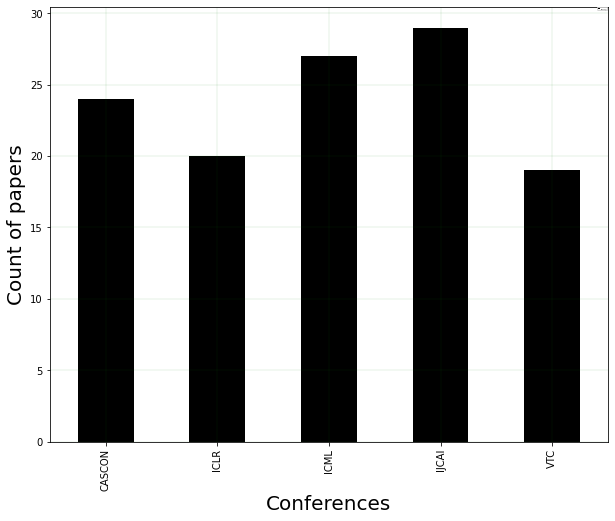

In [259]:
import matplotlib.pyplot as plt
plt.clf()
conferences_df[['conference','download_id']].groupby('conference').count().plot(kind='bar',figsize=(10, 8),color='black')
plt.ylabel('Count of papers', fontsize=20)
plt.xlabel('Conferences', fontsize=20)
plt.legend(fontsize=0)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

# Scatter plot:
It is a mainstay of statistical visualization. It shows  the joint distribution of two variables using a cloud of points, where each point represents an observation in the dataset. This depiction allows the eye to infer a substantial amount of information about whether there is any meaningful relationship between them.

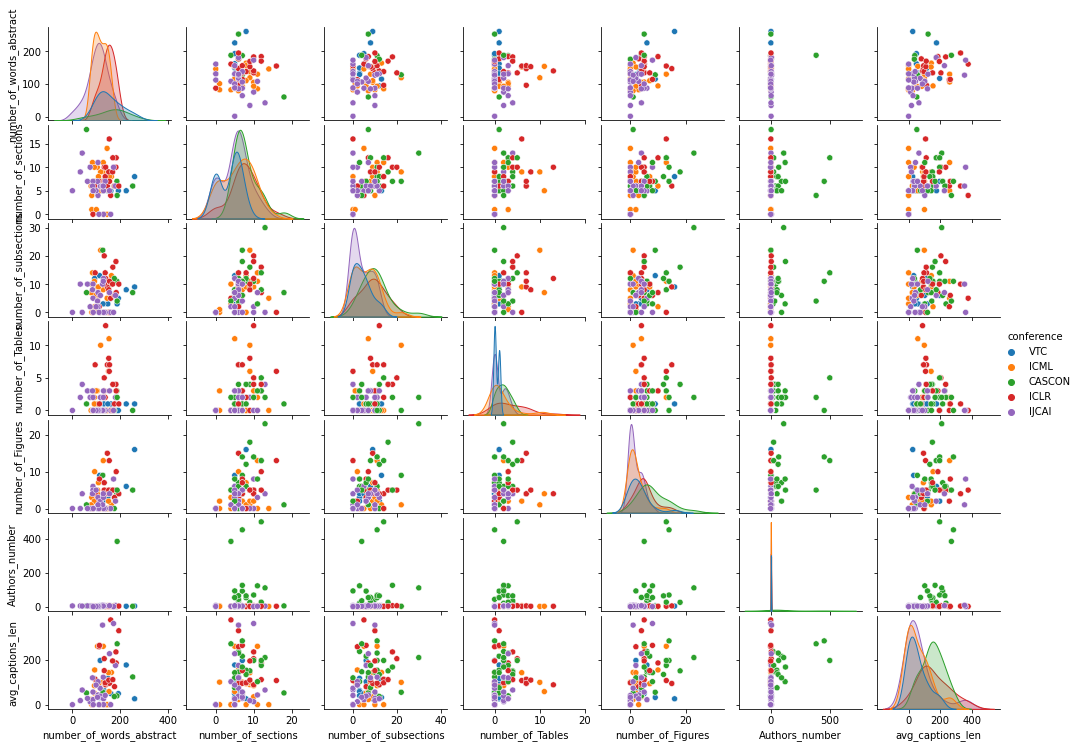

In [323]:
# Plotting Scatter Matrix
# just numeric excluding latitude and city
import seaborn as sns
g=sns.pairplot(data=cleaned_data, hue="conference",diag_kind="kde");
g.fig.set_size_inches(15,10)


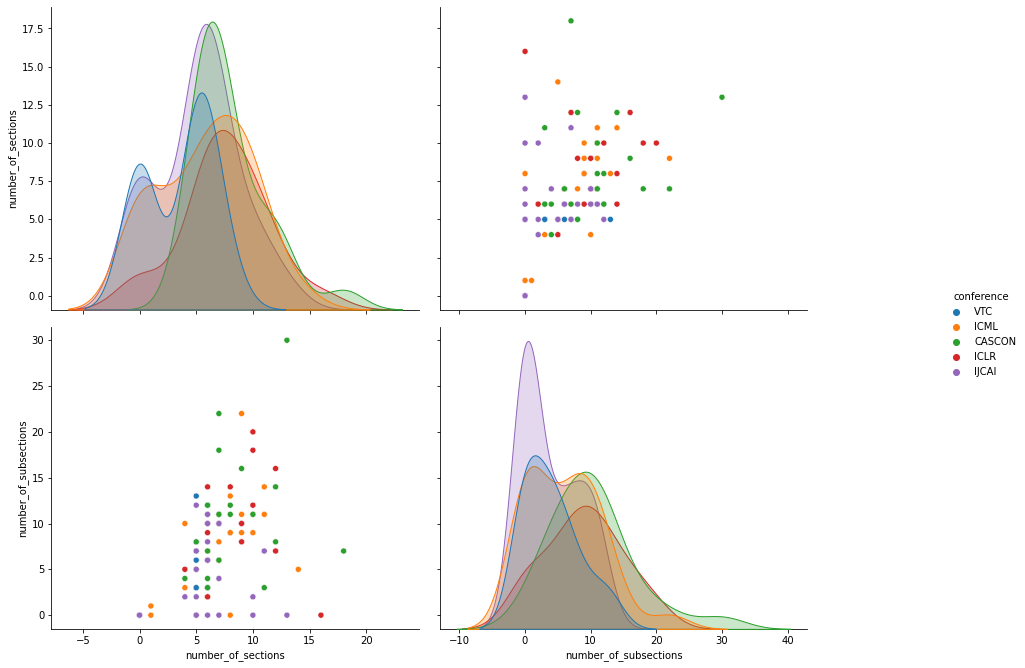

In [327]:
# Plotting Scatter Matrix
# just numeric excluding latitude and city
import seaborn as sns
g=sns.pairplot(data=cleaned_data[['number_of_sections','number_of_subsections','conference']], hue="conference",diag_kind="kde");
g.fig.set_size_inches(15,10)

Text(0.5, 1.0, 'Correlation Matrix Plot')

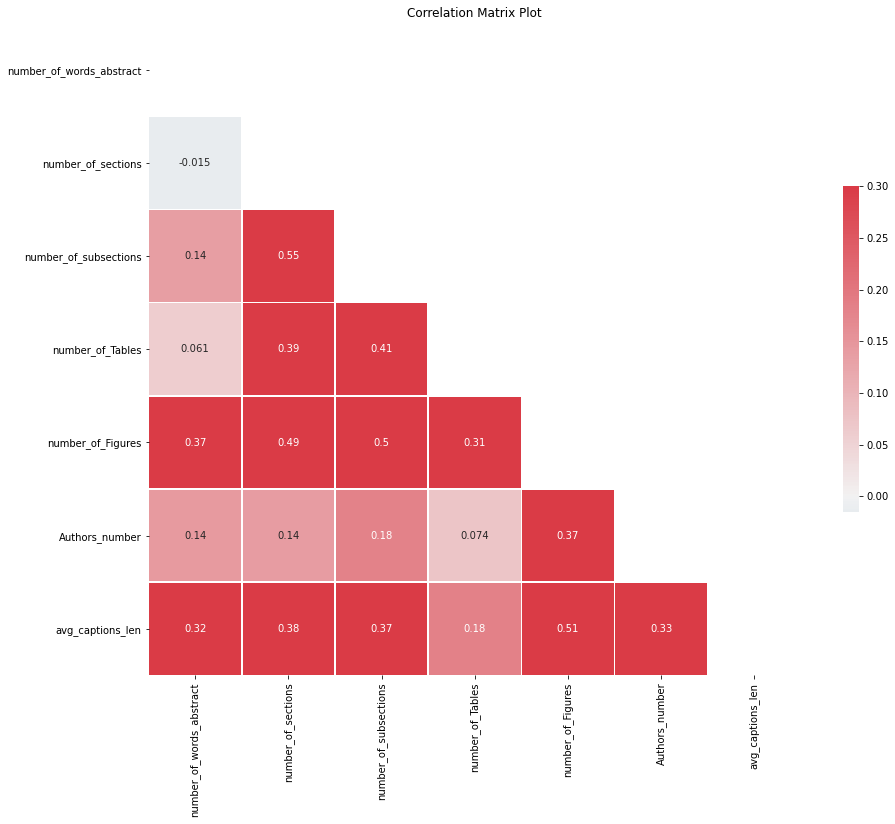

In [325]:
corr = cleaned_data.iloc[:,:].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.title('Correlation Matrix Plot')

<Figure size 432x288 with 0 Axes>

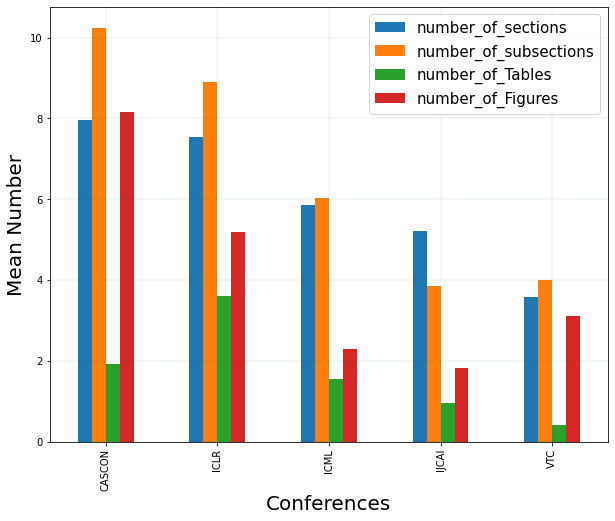

In [269]:
import matplotlib.pyplot as plt
plt.clf()
conferences_df[['conference','number_of_sections','number_of_subsections','number_of_Tables','number_of_Figures',
                ]].groupby('conference').mean().plot(kind='bar',figsize=(10, 8))
plt.ylabel('Mean Number', fontsize=20)
plt.xlabel('Conferences', fontsize=20)
plt.legend(fontsize=15)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

<Figure size 432x288 with 0 Axes>

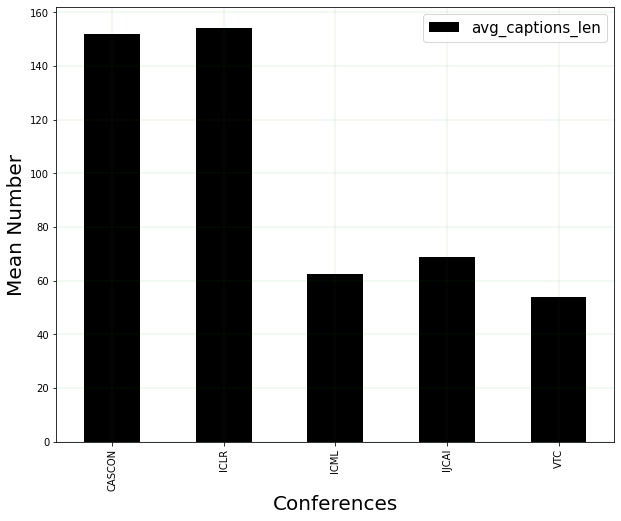

In [260]:
import matplotlib.pyplot as plt
plt.clf()
conferences_df[['conference','avg_captions_len']].groupby('conference').mean().plot(kind='bar',figsize=(10, 8), color=['black'])
plt.ylabel('Mean Number', fontsize=20)
plt.xlabel('Conferences', fontsize=20)
plt.legend(fontsize=15)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

<Figure size 432x288 with 0 Axes>

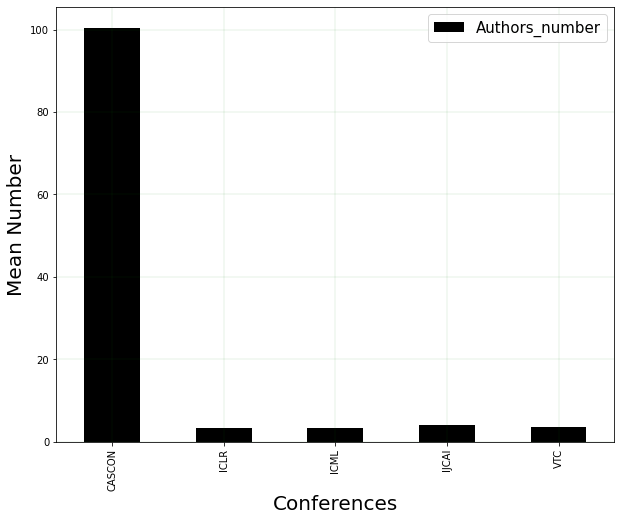

In [238]:
import matplotlib.pyplot as plt
plt.clf()
conferences_df[['conference','Authors_number']].groupby('conference').mean().plot(kind='bar',figsize=(10, 8), color=['black'])
plt.ylabel('Mean Number', fontsize=20)
plt.xlabel('Conferences', fontsize=20)
plt.legend(fontsize=15)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

<Figure size 432x288 with 0 Axes>

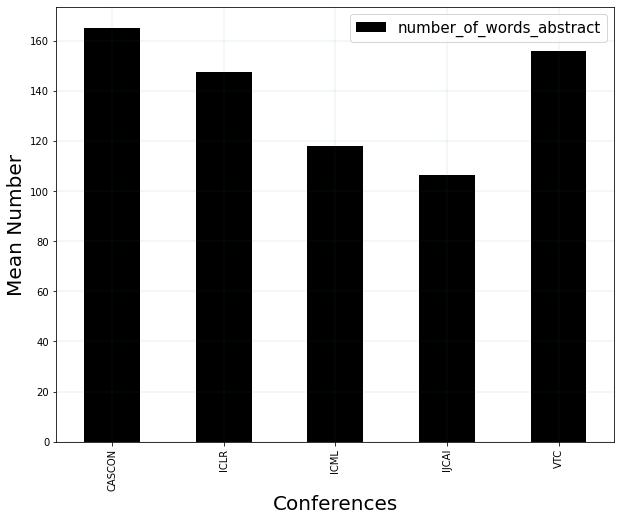

In [239]:
import matplotlib.pyplot as plt
plt.clf()
conferences_df[['conference','number_of_words_abstract']].groupby('conference').mean().plot(kind='bar',figsize=(10, 8), color=['black'])
plt.ylabel('Mean Number', fontsize=20)
plt.xlabel('Conferences', fontsize=20)
plt.legend(fontsize=15)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

In [318]:
conf=conferences_df[['conference','download_id',"number_of_words_abstract",'number_of_sections',
                'number_of_subsections','number_of_Tables','number_of_Figures','Authors_number',"avg_captions_len"]].groupby('conference')
CASCON=conf.get_group('CASCON')
ICLR=conf.get_group('ICLR')
ICML=conf.get_group('ICML')
IJCAI=conf.get_group('IJCAI')


In [320]:
ICLR

,conference,download_id,number_of_words_abstract,number_of_sections,number_of_subsections,number_of_Tables,number_of_Figures,Authors_number,avg_captions_len
70,ICLR,1411.3784v3,113.0,6.0,2.0,0.0,2.0,1,257
71,ICLR,1511.06394v4,161.0,4.0,5.0,0.0,5.0,2,376
72,ICLR,1802.07088v1,177.0,6.0,6.0,1.0,3.0,3,80
73,ICLR,1804.06216v2,87.0,0.0,0.0,0.0,0.0,4,0
74,ICLR,1806.05337v2,184.0,12.0,7.0,3.0,10.0,3,185
75,ICLR,1810.05997v5,155.0,16.0,0.0,6.0,13.0,3,107
76,ICLR,1811.09620v2,183.0,10.0,18.0,4.0,5.0,6,234
77,ICLR,1902.08412v1,NaN,0.0,0.0,0.0,0.0,2,0
78,ICLR,1903.09239v1,134.0,10.0,20.0,5.0,5.0,6,204
79,ICLR,1905.08101v1,114.0,7.0,6.0,1.0,8.0,2,263


# ICLR

In [287]:
ICLR=ICLR.set_index('download_id')
ICLR.head()

,conference,number_of_words_abstract,number_of_sections,number_of_subsections,number_of_Tables,number_of_Figures,Authors_number,avg_captions_len
download_id,,,,,,,,
1411.3784v3,ICLR,113.0,6.0,2.0,0.0,2.0,1,257
1511.06394v4,ICLR,161.0,4.0,5.0,0.0,5.0,2,376
1802.07088v1,ICLR,177.0,6.0,6.0,1.0,3.0,3,80
1804.06216v2,ICLR,87.0,0.0,0.0,0.0,0.0,4,0
1806.05337v2,ICLR,184.0,12.0,7.0,3.0,10.0,3,185


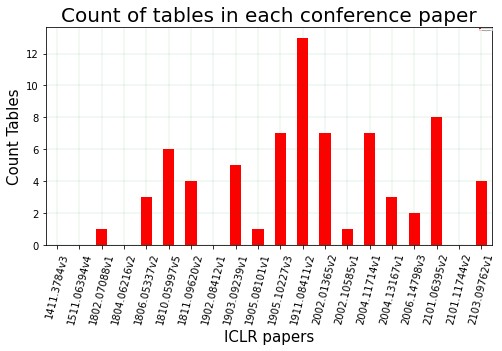

In [288]:
import matplotlib.pyplot as plt
plt.clf()
ICLR['number_of_Tables'].plot(kind='bar',figsize=(8, 4),color=['red'])
plt.ylabel('Count Tables', fontsize=15)
plt.title('Count of tables in each conference paper',fontsize=20)
plt.xlabel('ICLR papers', fontsize=15)
plt.legend(fontsize=0 )
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

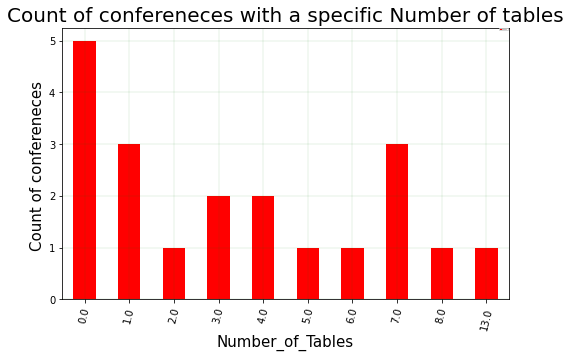

In [291]:
ICLR[['number_of_Tables','conference']].groupby('number_of_Tables').count().plot(kind='bar',figsize=(8, 5),color='red')
plt.title('Count of confereneces with a specific Number of tables',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('Number_of_Tables', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

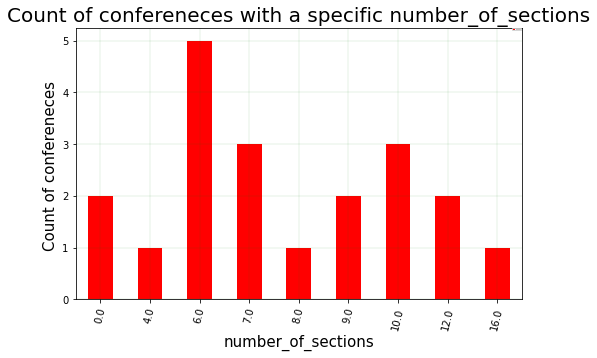

In [295]:
ICLR[['number_of_sections','conference']].groupby('number_of_sections').count().plot(kind='bar',figsize=(8, 5),color='red')
plt.title('Count of confereneces with a specific number_of_sections',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('number_of_sections', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

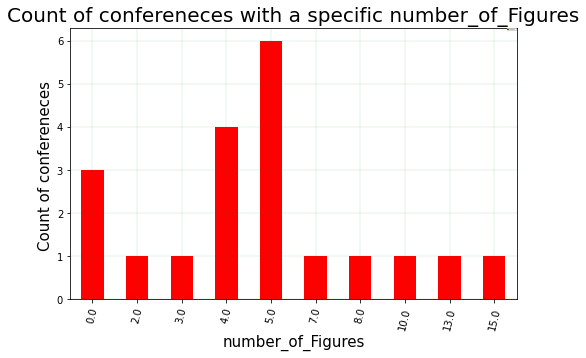

In [296]:
ICLR[['number_of_Figures','conference']].groupby('number_of_Figures').count().plot(kind='bar',figsize=(8, 5),color='red')
plt.title('Count of confereneces with a specific number_of_Figures',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('number_of_Figures', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

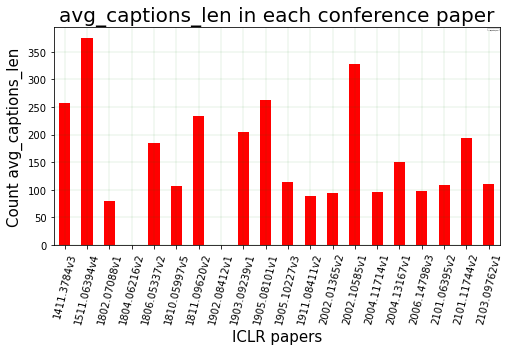

In [309]:
import matplotlib.pyplot as plt
plt.clf()
ICLR['avg_captions_len'].plot(kind='bar',figsize=(8, 4),color=['red'])
plt.ylabel('Count avg_captions_len', fontsize=15)
plt.title('avg_captions_len in each conference paper',fontsize=20)
plt.xlabel('ICLR papers', fontsize=15)
plt.legend(fontsize=0 )
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

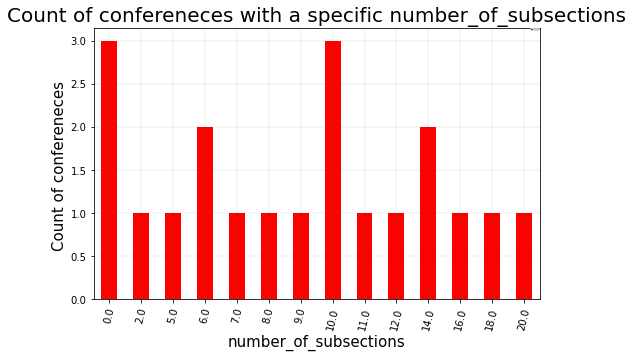

In [304]:
ICLR[['number_of_subsections','conference']].groupby('number_of_subsections').count().plot(kind='bar',figsize=(8, 5),color='red')
plt.title('Count of confereneces with a specific number_of_subsections',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('number_of_subsections', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

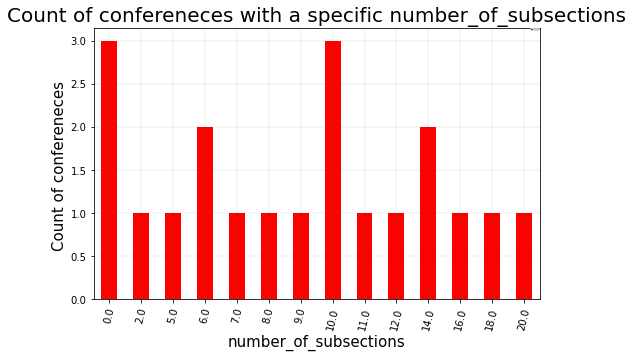

In [303]:
ICLR[['number_of_subsections','conference']].groupby('number_of_subsections').count().plot(kind='bar',figsize=(8, 5),color='red')
plt.title('Count of confereneces with a specific number_of_subsections',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('number_of_subsections', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

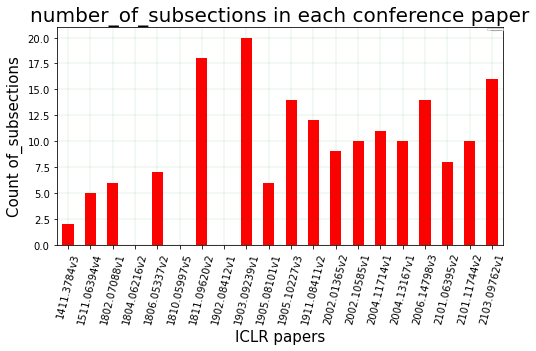

In [310]:
import matplotlib.pyplot as plt
plt.clf()
ICLR['number_of_subsections'].plot(kind='bar',figsize=(8, 4),color=['red'])
plt.ylabel('Count of_subsections', fontsize=15)
plt.title('number_of_subsections in each conference paper',fontsize=20)
plt.xlabel('ICLR papers', fontsize=15)
plt.legend(fontsize=0 )
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

# ICML

In [317]:
ICML=ICML.set_index('download_id')
ICML.head()

,conference,number_of_words_abstract,number_of_sections,number_of_subsections,number_of_Tables,number_of_Figures,Authors_number,avg_captions_len
download_id,,,,,,,,
1711.09576v4,ICML,NaN,0.0,0.0,0.0,0.0,3,0
1805.08196v1,ICML,NaN,4.0,3.0,0.0,0.0,2,0
1807.01961v2,ICML,85.0,11.0,14.0,0.0,0.0,3,0
2106.04815v2,ICML,82.0,1.0,0.0,0.0,0.0,5,0
1704.02685v2,ICML,137.0,9.0,11.0,0.0,5.0,3,89


<Figure size 432x288 with 0 Axes>

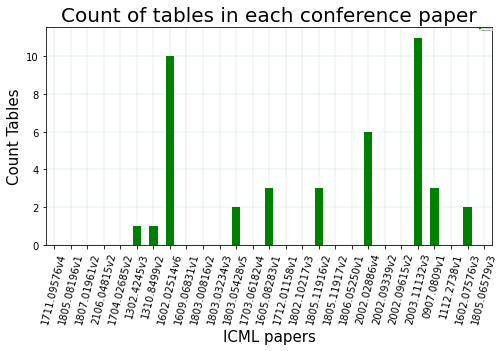

In [245]:
import matplotlib.pyplot as plt
plt.clf()
ICML.plot(kind='bar',figsize=(8, 4),color= 'green')
plt.ylabel('Count Tables', fontsize=15)
plt.title('Count of tables in each conference paper',fontsize=20)
plt.xlabel('ICML papers', fontsize=15)
plt.legend(fontsize=0 )
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

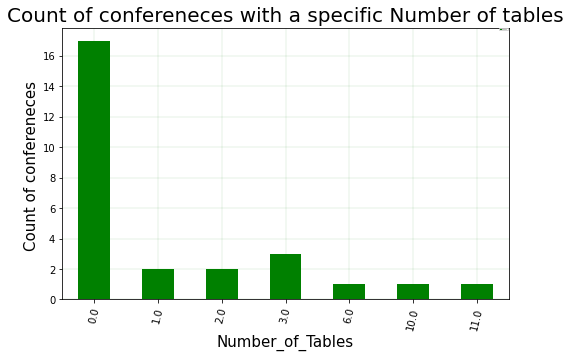

In [246]:
ICML.groupby('number_of_Tables').count().plot(kind='bar',figsize=(8, 5),color= 'green')
plt.title('Count of confereneces with a specific Number of tables',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('Number_of_Tables', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

# IJCAI

In [156]:
IJCAI=IJCAI.set_index('download_id')
IJCAI.head()

,conference,number_of_Tables
download_id,,
0905.3755v1,IJCAI,2.0
0905.3766v1,IJCAI,0.0
0905.3769v1,IJCAI,3.0
2003.01416v2,IJCAI,0.0
2007.07670v1,IJCAI,0.0


<Figure size 432x288 with 0 Axes>

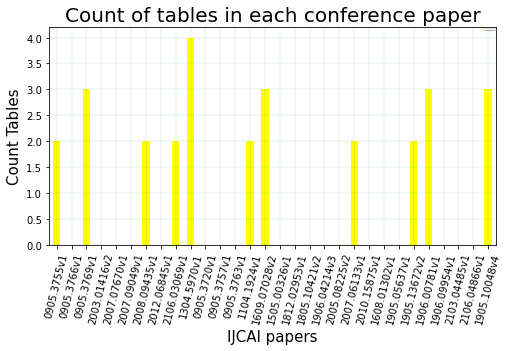

In [174]:
import matplotlib.pyplot as plt
plt.clf()
IJCAI.plot(kind='bar',figsize=(8, 4),color= 'yellow')

plt.ylabel('Count Tables', fontsize=15)
plt.title('Count of tables in each conference paper',fontsize=20)
plt.xlabel('IJCAI papers', fontsize=15)
plt.legend(fontsize=0 )
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

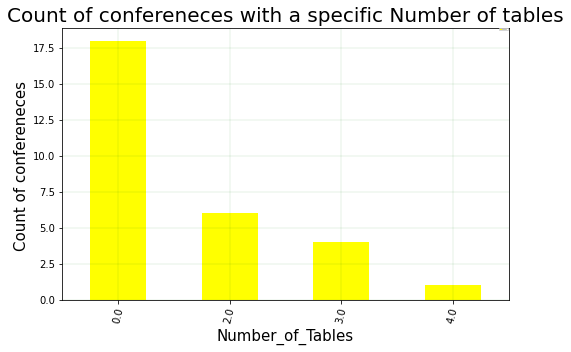

In [173]:
IJCAI.groupby('number_of_Tables').count().plot(kind='bar',figsize=(8, 5),color= 'yellow')
plt.title('Count of confereneces with a specific Number of tables',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('Number_of_Tables', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

# CASCON

In [159]:
CASCON=CASCON.set_index('download_id')
CASCON.head()

,conference,number_of_Tables
download_id,,
0909.2187v1,CASCON,NaN
1807.02274v1,CASCON,3.0
1207.3257v2,CASCON,0.0
1405.0749v1,CASCON,0.0
2008.07092v1,CASCON,1.0


<Figure size 432x288 with 0 Axes>

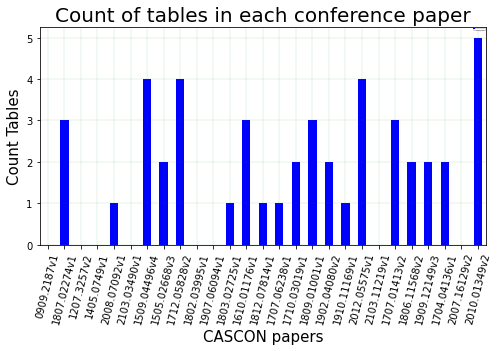

In [175]:
import matplotlib.pyplot as plt
plt.clf()
CASCON.plot(kind='bar',figsize=(8, 4),color= 'blue')

plt.ylabel('Count Tables', fontsize=15)
plt.title('Count of tables in each conference paper',fontsize=20)
plt.xlabel('CASCON papers', fontsize=15)
plt.legend(fontsize=0 )
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

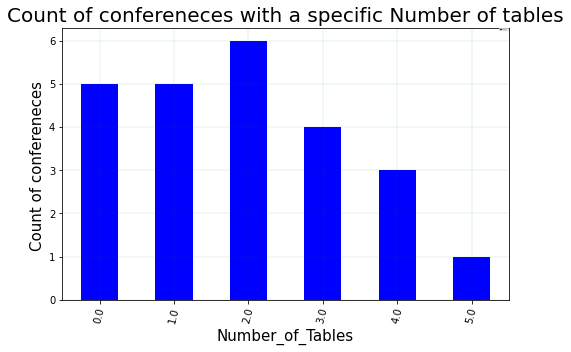

In [176]:
CASCON.groupby('number_of_Tables').count().plot(kind='bar',figsize=(8, 5),color= 'blue')
plt.title('Count of confereneces with a specific Number of tables',fontsize=20)
plt.ylabel('Count of confereneces ', fontsize=15)
plt.xlabel('Number_of_Tables', fontsize=15)
plt.legend(fontsize=0)
plt.xticks(rotation=76)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

In [ ]:
box plot

In [ ]:
stacked bar chart

# old code

In [61]:
"""import glob
import os
path_to_conferences = "./unzipped-papers"
conferences = os.listdir(path_to_conferences)
for conference in conferences:
    print(conference)
    path_to_each_conferences=path_to_conferences+"/"+conference
    papers = os.listdir(path_to_each_conferences)

    for paper in papers:
        print('---------------')
        
        path_to_each_conference_paper=path_to_each_conferences+"/"+paper
        
        
        
        #add a if to test if we have already worked on that paper: e.g if paper is in df["title"].values then pass
    
        for root, dirs, files in os.walk(path_to_each_conference_paper):
            number_of_tex_files=0

            for file in files:
                if file.endswith(".tex"):
                    number_of_tex_files+=1
                    path_to_each_conference_paper_file=os.path.join(root , file).replace("\\","/")
                    print(path_to_each_conference_paper_file)
                    
                    try:
                        data = open(path_to_each_conference_paper_file,encoding="utf8").read()
                    except UnicodeDecodeError:
                        data = open(path_to_each_conference_paper_file).read()
                    # directory already exists
                    pass
                        
                                    
                    if "\documentclass" in data:
                        #print(" The \documentclass detected in ", file )
                        main_tex_file=data
            
            if number_of_tex_files==1:
                print("=============================")
                print(paper)
                print("only 1 tex file detected")
                conferences_df=easy_function(paper,data,conferences_df)
                
            elif number_of_tex_files>1:
                print("more than 1 tex file , Treating now main_tex_file")
                conferences_df=easy_function(paper,main_tex_file,conferences_df)
                #hard_function(main_tex_file)
                       
    
    """

'import glob\nimport os\npath_to_conferences = "./unzipped-papers"\nconferences = os.listdir(path_to_conferences)\nfor conference in conferences:\n    print(conference)\n    path_to_each_conferences=path_to_conferences+"/"+conference\n    papers = os.listdir(path_to_each_conferences)\n\n    for paper in papers:\n        print(\'---------------\')\n        \n        path_to_each_conference_paper=path_to_each_conferences+"/"+paper\n        \n        \n        \n        #add a if to test if we have already worked on that paper: e.g if paper is in df["title"].values then pass\n    \n        for root, dirs, files in os.walk(path_to_each_conference_paper):\n            number_of_tex_files=0\n\n            for file in files:\n                if file.endswith(".tex"):\n                    number_of_tex_files+=1\n                    path_to_each_conference_paper_file=os.path.join(root , file).replace("\\","/")\n                    print(path_to_each_conference_paper_file)\n                    \

# Test on one file

In [82]:
data = open('./unzipped-papers/CASCON/1405.0749/simple.tex',encoding="utf8").read()

In [83]:
data

'\\documentclass[10pt, conference, compsocconf]{IEEEtran}\n\n\\usepackage{pgfplots}\n\\usepackage{algpseudocode}\n\\usepackage{algorithm}\n\\usepackage{enumerate}\n\\usepackage{cite}\n\\usepackage{amsfonts}\n\\usepackage[stable]{footmisc}\n\n\\hyphenation{op-tical net-works semi-conduc-tor}\n\n\\begin{document}\n\n\\title{A Brief History of Web Crawlers}\n\n\\author{\\IEEEauthorblockN{Seyed M. Mirtaheri, Mustafa Emre Din\\c{c}t\\"{u}rk, Salman Hooshmand, Gregor V. Bochmann, Guy-Vincent Jourdan}\n\\IEEEauthorblockA{School of Electrical Engineering and Computer Science\\\\\nUniversity of Ottawa\\\\\nOttawa, Ontario, Canada\\\\\n\\{smirt016,mdinc075, shooshmand\\}@uottawa.ca, \\{bochmann,gvj\\}@eecs.uottawa.ca}\\\\\n\\IEEEauthorblockN{Iosif Viorel Onut}\n\\IEEEauthorblockA{Security AppScan\\textsuperscript{\\textregistered} Enterprise, IBM\\\\\n770 Palladium Dr\\\\\nOttawa, Ontario, Canada\\\\\nvioonut@ca.ibm.com}\n}\n\n\\maketitle\n\n\\begin{abstract}\n\nWeb crawlers have a long and inte

In [84]:
# delete commented  data
commented_data=re.findall(r'%(.*?)\n', data, re.S)
uncommented_data=data

for comment in commented_data:
    uncommented_data= uncommented_data.replace('%'+comment+'\n',"")

    
    
    
    # exploring abstarct     
abstract= re.findall(r'\\begin{abstract}(.*?)\\end{abstract}', uncommented_data, re.S)
print(abstract)

if (abstract!=[]):
    cleanabstract= abstract[0].replace('\n',"")
 
    number_of_words_abstract= len(cleanabstract.split())
    conferences_df.loc[conferences_df['download']==float(paper),'Abstarct'] = cleanabstract
    conferences_df.loc[conferences_df['download']==float(paper),'number_of_words_abstract'] = number_of_words_abstract
    
    #Sections
number_of_sections=len(re.findall(r'\\section{.*?}', uncommented_data, re.S))
conferences_df.loc[conferences_df['download']==float(paper),'number_of_sections'] = number_of_sections
print(number_of_sections)

#SubSections
number_of_subsections=len(re.findall(r'..\\subsection{.*?}', uncommented_data, re.S)) 
conferences_df.loc[conferences_df['download']==float(paper),'number_of_subsections']= number_of_subsections
print(number_of_subsections)

 #Tables
number_of_Tables=len(re.findall(r'begin{table}', uncommented_data, re.S))
conferences_df.loc[conferences_df['download']==float(paper),'number_of_Tables']= number_of_Tables
print(number_of_Tables)

#Figures
number_of_Figures=len(re.findall(r'\\begin\{figure}', uncommented_data, re.S))
conferences_df.loc[conferences_df['download']==float(paper),'number_of_Figures'] = number_of_Figures
print(number_of_Figures)

['\n\nWeb crawlers have a long and interesting history. \nEarly web crawlers collected statistics about the web. In addition to collecting statistics about the web and indexing the applications for search engines, \nmodern crawlers can be used to perform accessibility and vulnerability checks on the application. \n\nQuick expansion of the web, and the complexity added to web applications have made the process of crawling a very challenging one. \nThroughout the history of web crawling many researchers and industrial groups \naddressed different issues and challenges that web crawlers face. Different solutions have been proposed to reduce the time and cost of crawling. \nPerforming an exhaustive crawl is a challenging question. \nAdditionally, capturing the model of a modern web application and extracting data from it automatically is another open question. \n\nWhat follows is a brief history of different technique and algorithms used from the early days of crawling up to \nthe recent d

In [103]:
#References
number_ref=len(re.findall(r'\\ref{.*?} ', uncommented_data, re.S))
number_ref

14

In [101]:
re.findall(r'..ref{.*?}' , uncommented_data, re.S)

[' \\ref{tableStages}',
 ' \\ref{crawlStrategies}',
 ' \\ref{domEquivalency}',
 ' \\ref{parallelCrawling}',
 ' \\ref{automatedTesting}',
 ' \\ref{pageRank}',
 ' \\ref{secRequirements}',
 ' \\ref{taxoTrad}',
 ' \\ref{taxoDeep}',
 ' \\ref{taxoRIA}',
 ' \\ref{figArchTrad}',
 ' \\ref{tabTaxoTrad}',
 ' \\ref{figArchDeep}',
 ' \\ref{tabTaxoDeep}',
 ' \\ref{figArchRIA}',
 ' \\ref{tabTaxoRIA}']

In [95]:
uncommented_data

'\\documentclass[10pt, conference, compsocconf]{IEEEtran}\n\n\\usepackage{pgfplots}\n\\usepackage{algpseudocode}\n\\usepackage{algorithm}\n\\usepackage{enumerate}\n\\usepackage{cite}\n\\usepackage{amsfonts}\n\\usepackage[stable]{footmisc}\n\n\\hyphenation{op-tical net-works semi-conduc-tor}\n\n\\begin{document}\n\n\\title{A Brief History of Web Crawlers}\n\n\\author{\\IEEEauthorblockN{Seyed M. Mirtaheri, Mustafa Emre Din\\c{c}t\\"{u}rk, Salman Hooshmand, Gregor V. Bochmann, Guy-Vincent Jourdan}\n\\IEEEauthorblockA{School of Electrical Engineering and Computer Science\\\\\nUniversity of Ottawa\\\\\nOttawa, Ontario, Canada\\\\\n\\{smirt016,mdinc075, shooshmand\\}@uottawa.ca, \\{bochmann,gvj\\}@eecs.uottawa.ca}\\\\\n\\IEEEauthorblockN{Iosif Viorel Onut}\n\\IEEEauthorblockA{Security AppScan\\textsuperscript{\\textregistered} Enterprise, IBM\\\\\n770 Palladium Dr\\\\\nOttawa, Ontario, Canada\\\\\nvioonut@ca.ibm.com}\n}\n\n\\maketitle\n\n\\begin{abstract}\n\nWeb crawlers have a long and inte